# Coronavirus News Sentiment: Fox News vs CNN

### Get the articles (limit of 100) for developer account unfortunately

In [1]:
from newsapi import NewsApiClient
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
#from pandas.io.json import json_normalize

# Init
newsapi = NewsApiClient(api_key='43f140ef71bd401f8a3add1c1e514b17')

fox_articles = newsapi.get_everything(q='coronavirus', sources="fox-news", page_size=100, sort_by="publishedAt", language="en")["articles"]
cnn_articles = newsapi.get_everything(q='coronavirus', sources="cnn", page_size=100, sort_by="publishedAt", language="en")["articles"]

### Use VADER to get the sentiment scores

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
fox_sentiment_results = []
cnn_sentiment_results = []

for article in fox_articles:
    if article["description"] == None:
        continue
    pol_score = sia.polarity_scores(article["description"])
    pol_score['headline'] = article["description"]
    fox_sentiment_results.append(pol_score)

    
for article in cnn_articles:
    if article["description"] == None:
        continue
    pol_score = sia.polarity_scores(article["description"])
    pol_score['headline'] = article["description"]
    cnn_sentiment_results.append(pol_score)

### Create dataframes from results and assign labels based on compound threshold

In [3]:
fox_df = pd.DataFrame.from_records(fox_sentiment_results)
cnn_df = pd.DataFrame.from_records(cnn_sentiment_results)

In [4]:
fox_df['label'] = 0
fox_df.loc[fox_df['compound'] > 0.3, 'label'] = 1
fox_df.loc[fox_df['compound'] < -0.3, 'label'] = -1

fox_df = fox_df[['headline', 'label']]

In [5]:
cnn_df['label'] = 0
cnn_df.loc[cnn_df['compound'] > 0.3, 'label'] = 1
cnn_df.loc[cnn_df['compound'] < -0.3, 'label'] = -1

cnn_df = cnn_df[['headline', 'label']]

### Fox News Headline Sample

In [6]:
from pprint import pprint

print("Positive headlines:\n")
pprint(list(fox_df[fox_df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(fox_df[fox_df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['"Special Report" anchor Bret Baier appeared on "Watters\' World" Saturday where he gave an update to his reporting on sources saying there\'s\xa0increasing confidence that\xa0the coronavirus '
 'pandemic began in a Wuhan, China, laboratory as part of the Communist countr…',
 'The White House task force on reopening the economy — a seeming cast of thousands drawn from inside and outside government, much heralded by the president but still somewhat amorphous — is a '
 'curious affair.',
 'Vice President Mike Pence on Saturday told Air Force Academy graduates that they will inspire Americans with the confidence that the country can overcome the “invisible enemy” in the form of the '
 'coronavirus crisis sweeping the country.',
 'Medal of Honor recipient Bennie Adkins of Alabama has succumbed to the coronavirus after a long battle.',
 'As the escalating coronavirus pandemic has shuttered concerts and music festivals all over the world, country singer Brad Paisley has

### CNN News Headline Sample

In [7]:
from pprint import pprint

print("Positive headlines:\n")
pprint(list(cnn_df[cnn_df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(cnn_df[cnn_df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['Celebrities like Snoop Dogg, Lin-Manuel Miranda, Taraji P. Henson and Sean "Diddy" Combs came together to give thanks and support for underserved communities hit hard by the coronavirus pandemic.',
 "The novel coronavirus won't be halting New York weddings anymore.",
 'The majority of governors in the United States have ordered or recommended that statewide school closures continue for the rest of the academic year to help reduce the spread of the novel '
 'coronavirus.',
 'A congressman on Friday called for the Securities and Exchange Commission to investigate the leak of a video showing physicians at the University of Chicago speaking enthusiastically about an '
 'experimental drug to treat Covid-19.',
 'MTA in New York launches new "Keep Them Covered" campaign to make sure riders cover their mouth and nose amid coronavirus pandemic.']

Negative headlines:

["The simmering tension between President Donald Trump and the nation's governors over coronavirus testin

### Plot the distribution of positive, negative, and neutral articles for Fox News

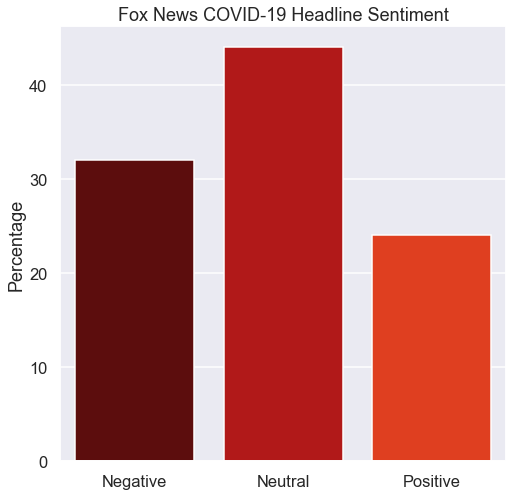

In [8]:
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='hot')
fig, ax = plt.subplots(figsize=(8, 8))

counts = fox_df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_title('Fox News COVID-19 Headline Sentiment')

plt.show()

### Plot the distribution of positive, negative, and neutral articles for CNN News

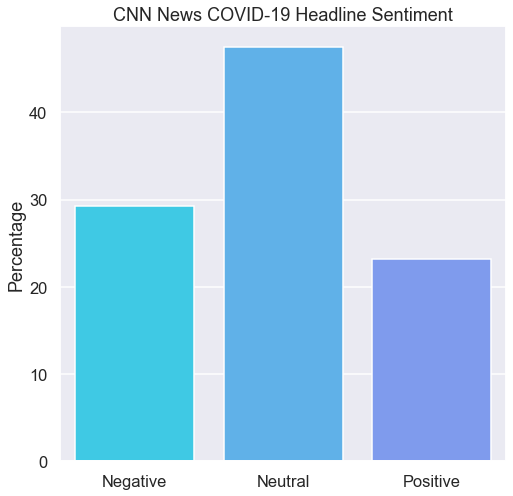

In [9]:
sns.set(style='darkgrid', context='talk', palette='cool')
fig, ax = plt.subplots(figsize=(8, 8))

counts = cnn_df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_title('CNN News COVID-19 Headline Sentiment')

plt.show()

### Function to remove stopwords and punctuation and tokenize

In [89]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
stop_words = stop_words + ["coronavirus", "new", "news", "said", "part", "gave", "pandemic", "u", "saturday", "friday", "one", "p", "li", "says"]

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    return tokens

### Most frequent words associated with positive headlines on Fox

In [104]:
from matplotlib import rcParams
import matplotlib.cm as cm
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

stopwords = STOPWORDS

def makeWordCloud(freqs, title):
    rcParams['figure.figsize'] = 10, 20
    wordcloud = WordCloud(stopwords=stopwords, background_color="black", max_words=25, width=800, height=400).generate_from_frequencies(freqs)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def makeFreqBarChart(freqs, title):
    words = list(freqs.keys())
    counts = list(freqs.values())
    colors = cm.rainbow(np.linspace(0, 1, 10))
    rcParams['figure.figsize'] = 20, 10
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)

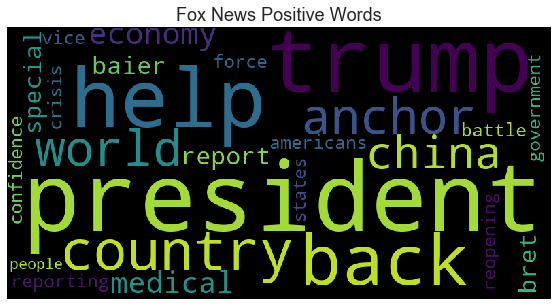

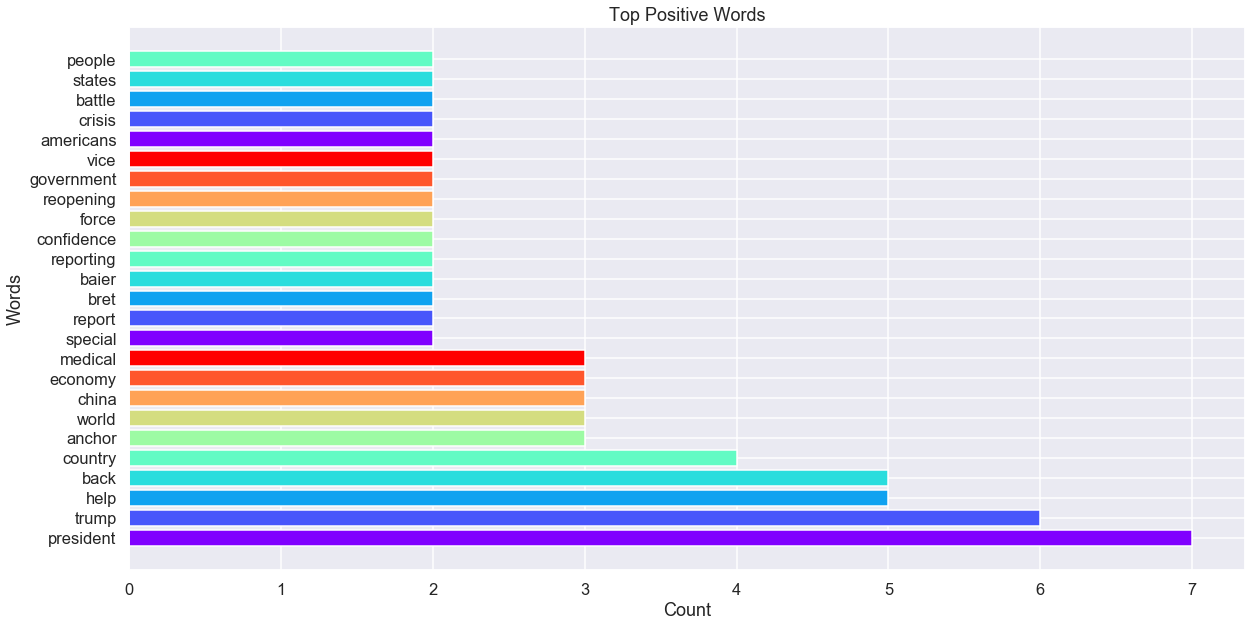

In [103]:
pos_lines = list(fox_df[fox_df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

word_freq = dict(pos_freq.most_common(25))

makeWordCloud(word_freq, "Fox News Positive Words")
makeFreqBarChart(word_freq, "Fox News Top Positive Words")

### Most frequent words associated with negative headlines on Fox

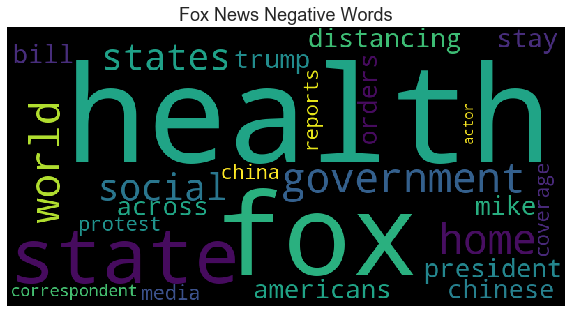

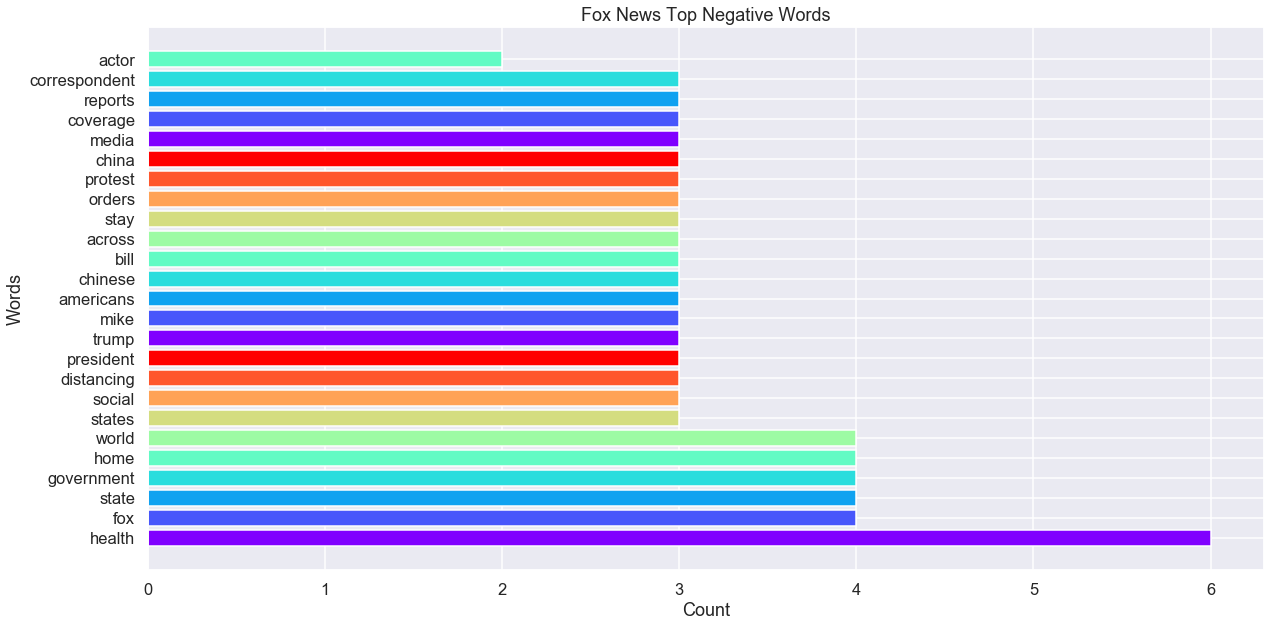

In [105]:
neg_lines = list(fox_df[fox_df.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

word_freq = dict(neg_freq.most_common(25))

makeWordCloud(word_freq, "Fox News Negative Words")
makeFreqBarChart(word_freq, "Fox News Top Negative Words")

### Most frequent words associated with positive headlines on CNN

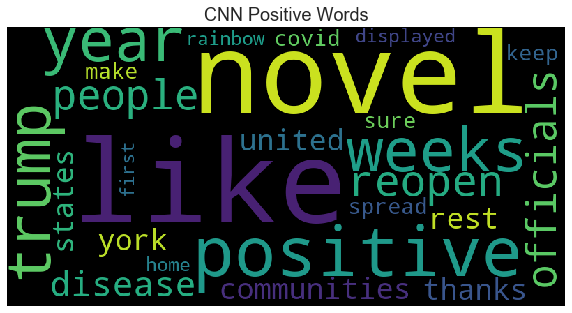

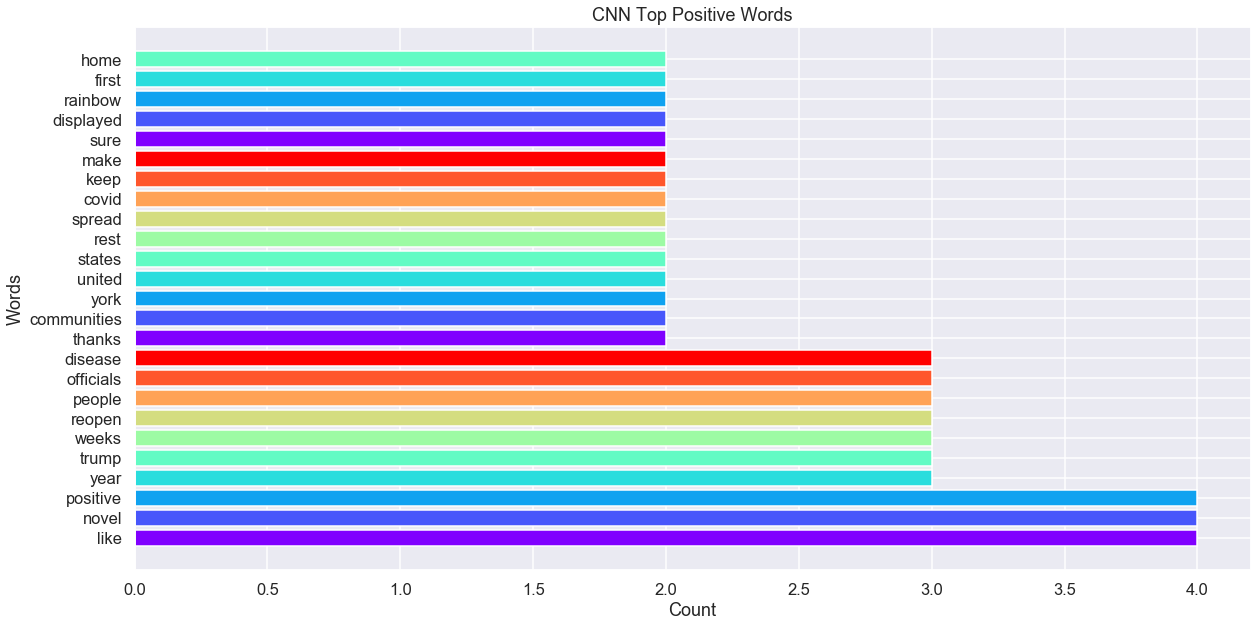

In [106]:
pos_lines = list(cnn_df[cnn_df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

word_freq = dict(pos_freq.most_common(25))

makeWordCloud(word_freq, "CNN Positive Words")
makeFreqBarChart(word_freq, "CNN Top Positive Words")

### Most frequent words associated with negative headlines on CNN

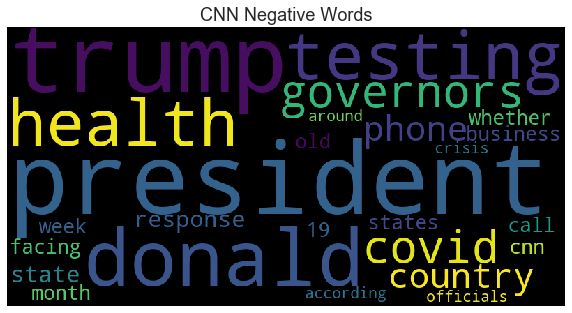

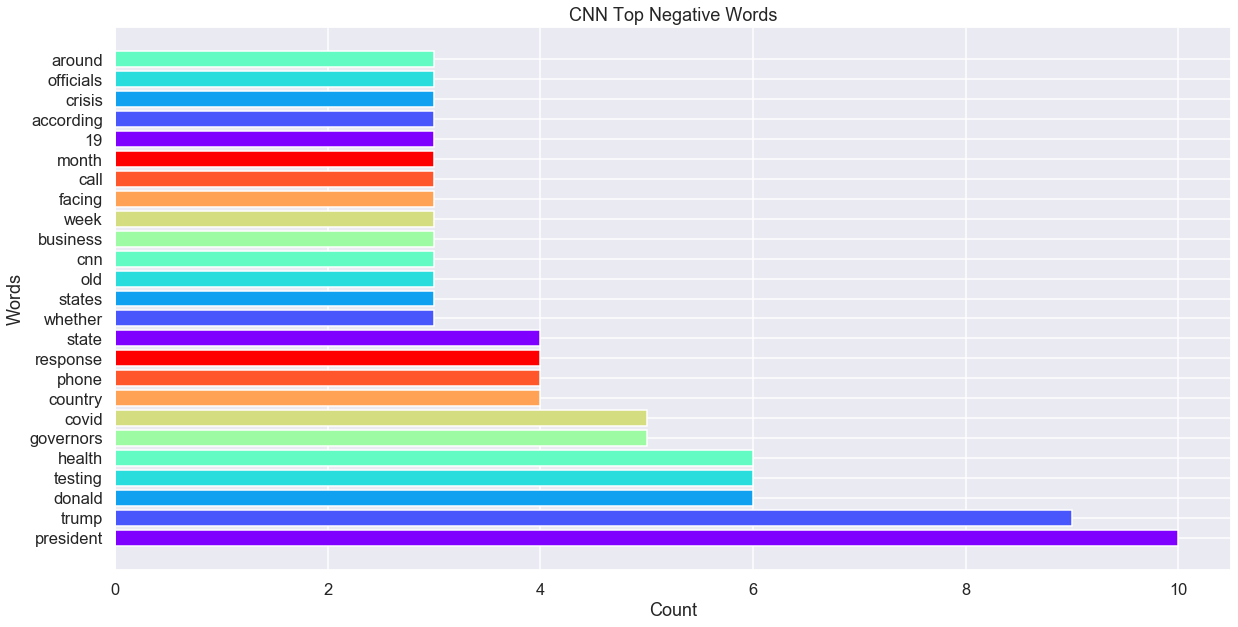

In [107]:
neg_lines = list(cnn_df[cnn_df.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(25)

word_freq = dict(neg_freq.most_common(25))

makeWordCloud(word_freq, "CNN Negative Words")
makeFreqBarChart(word_freq, "CNN Top Negative Words")

# Summary and Interesting Findings

Interestingly, the distribution of positive, negative, and neutral headlines was more or less the same on both news platforms. 

However, if you look at the frequency distribution for positive word tokens on Fox News you will find that **'trump'** and **'president'** are very highly ranked. **'hannity'** and **'economy'** also rank quite high. On the negative side you will find that **'democratic'** made the cut for the top 25 common words associated with negative headlines.

If you look at the frequency distribution for positive word tokens on CNN News, you will find that **'people'** and **'positive'** exist on the list of the top 25 most common positive-headline associated tokens. The word **'trump'** ranks significantly lower than on Fox. On the negative side, **'president'** has almost as many negative mentions as positive mentions on CNN. 

# Lack of Data

Unfortunately I was limited to only 100 articles, the data would be much more interesting with thousands of articles. Also I think 'coronavirus' should be added to the list of stopwords. 